# Number Plate detection

In [ ]:
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "/content/drive/MyDrive/numberplatedetection"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "license_plates_detection_train"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Licplatesdetection_train.csv"])
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [ ]:
rows = open(ANNOTS_PATH).read().strip().split("\n")
rows[0:10]

['img_id,ymin,xmin,ymax,xmax',
 '1.jpg,276,94,326,169',
 '10.jpg,311,395,344,444',
 '100.jpg,406,263,450,434',
 '101.jpg,283,363,315,494',
 '102.jpg,139,42,280,222',
 '103.jpg,437,320,475,450',
 '104.jpg,482,511,547,623',
 '105.jpg,281,452,330,535',
 '106.jpg,309,172,332,281']

In [ ]:
data = []
targets = []
filenames = []

# Assuming `rows` is a list of strings with each row containing comma-separated values
for i, row in enumerate(rows):
    if i == 0:  # Skip the first row if it's a header
        continue

    # Break the row into the filename and bounding box coordinates
    row = row.split(",")
    (filename, startY, startX, endY, endX) = row

    # Construct the full image path
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    # print(imagePath)  # Debugging: Print the image path

    # Load the image and process its dimensions
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]

    # Normalize the bounding box coordinates
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    # Resize the image to the target size and convert it to an array
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)

    # Append processed data
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)


In [ ]:
data[0].shape

(224, 224, 3)

In [ ]:
targets

[(0.11058823529411765,
  0.5786163522012578,
  0.1988235294117647,
  0.6834381551362684),
 (0.6181533646322379,
  0.6492693110647182,
  0.6948356807511737,
  0.7181628392484343),
 (0.3607681755829904,
  0.7422303473491774,
  0.5953360768175583,
  0.8226691042047533),
 (0.42705882352941177,
  0.5932914046121593,
  0.5811764705882353,
  0.660377358490566),
 (0.10268948655256724,
  0.25411334552102377,
  0.5427872860635696,
  0.5118829981718465),
 (0.438957475994513,
  0.7989031078610603,
  0.6172839506172839,
  0.8683729433272395),
 (0.700960219478738, 0.8811700182815356, 0.8545953360768176, 1.0),
 (0.5368171021377672,
  0.5903361344537815,
  0.6353919239904988,
  0.6932773109243697),
 (0.4195121951219512,
  0.5648994515539305,
  0.6853658536585366,
  0.6069469835466179),
 (0.44808743169398907,
  0.7294332723948812,
  0.6024590163934426,
  0.7769652650822669),
 (0.8381344307270233,
  0.17915904936014626,
  0.934156378600823,
  0.6928702010968921),
 (0.2860125260960334,
  0.65738161559888

In [ ]:
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)

In [ ]:
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [ ]:
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)

bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)


model = Model(inputs=vgg.input, outputs=bboxHead)
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,936,548 (68.42 MB)

 Trainable params: 3,221,860 (12.29 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

Epoch 1/25
11/26 ━━━━━━━━━━━━━━━━━━━━ 5:19 21s/step - loss: 0.0270

In [ ]:
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")

In [ ]:
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

import numpy as np
import imutils
import cv2
from google.colab.patches import cv2_imshow

# Set the path to the input image and the model
image_path = os.path.sep.join([BASE_PATH, "test","950.jpg"])
model_path = "/content/output/detector.h5"        # Replace with your trained model path

# Load the trained bounding box regression model
print("[INFO] Loading object detector...")
model = load_model(model_path, custom_objects={"mse": MeanSquaredError()})

# Load and preprocess the input image
print("[INFO] Processing the input image...")
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

# Make predictions
preds = model.predict(image)[0]
print(preds)
(startX, startY, endX, endY) = preds

# Load the original image with OpenCV
original_image = cv2.imread(image_path)
original_image = imutils.resize(original_image, width=600)
(h, w) = original_image.shape[:2]

# Scale the bounding box coordinates to the original image size
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

# Draw the predicted bounding box on the image
cv2.rectangle(original_image, (startX, startY), (endX, endY), (0, 255, 0), 2)

# Display the output image
cv2_imshow(original_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


#Number plate recognition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datetime import datetime

EPOCHS = 150
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
BATCH_SIZE = 16
IMG_SIZE = 224
IMG_HEIGHT = 128
IMG_WIDTH = 256
IMG_DIR = "dataset/data"
MODEL_DIR = "saved_models"
TRAINING_TYPE="pretrained"
LOG_DIR = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras import backend as K
from difflib import SequenceMatcher


In [ ]:
BASE_PATH = "/content/drive/MyDrive/numberplatedetection"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "license_plates_recognition_train"])
BASE_OUTPUT = "output"

In [ ]:
df = pd.read_csv(os.path.sep.join([BASE_PATH, "Licplatesrecognition_train.csv"]))
print(df.head(5))

    img_id      text
0    0.jpg  117T3989
1    1.jpg  128T8086
2   10.jpg   94T3458
3  100.jpg  133T6719
4  101.jpg   68T5979


In [ ]:
# Split indices for training and testing
train_indices, test_indices = train_test_split(df.index, test_size=0.1, random_state=42, shuffle=True)

# Create the `dtype` column and initialize with "train"
df["dtype"] = "train"

# Assign "test" to rows belonging to the testing set
df.loc[test_indices, "dtype"] = "test"

df["image_path"] = df["img_id"].apply(lambda x: os.path.join(IMAGES_PATH, x))




# Display the updated dataframe
df.head()

df.head()

,img_id,text,dtype,image_path
0,0.jpg,117T3989,train,/content/drive/MyDrive/numberplatedetection/li...
1,1.jpg,128T8086,train,/content/drive/MyDrive/numberplatedetection/li...
2,10.jpg,94T3458,train,/content/drive/MyDrive/numberplatedetection/li...
3,100.jpg,133T6719,train,/content/drive/MyDrive/numberplatedetection/li...
4,101.jpg,68T5979,train,/content/drive/MyDrive/numberplatedetection/li...


In [ ]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageOps

# Define characters based on your dataset
chars = "0123456789TN"  # Numbers 0-9 and Arabic 'T' and 'N'
chars = sorted([c for c in chars])

# Character to index map and reverse map
char_to_ind = tf.keras.layers.StringLookup(vocabulary=list(chars), mask_token=None)
ind_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_ind.get_vocabulary(), mask_token=None, invert=True)


In [ ]:
# Image dimensions.
height = 224
width = 224


In [ ]:
import numpy as np
import pandas as pd
from PIL import Image


# Updated image loading function
def load_image(image_path, target_size=(224, 224)):
    """
    Load an image, convert it to grayscale, resize it, and normalize.
    :param image_path: Path to the image file
    :param target_size: Target image dimensions (width, height)
    :return: Preprocessed image as a NumPy array
    """
    image = Image.open(image_path).convert('RGB')  # Convert to grayscale
    image = image.resize(target_size)           # Resize to target dimensions (width x height)
    image = np.array(image, dtype=np.float32)   # Convert to NumPy array
    image = image / 255.0                       # Normalize pixel values to [0, 1]
    return image       # Add channel dimension for TensorFlow

# Update prepare_dataset to handle only train and valid
def prepare_dataset(df, target_size=(224, 224)):
    """
    Prepare image and text datasets from the DataFrame.
    :param df: DataFrame containing image paths and text
    :param target_size: Target image dimensions (width, height)
    :return: Image and text arrays (X, y)
    """
    X = []
    y = []

    for _, row in df.iterrows():
        # Load and preprocess the image
        image = load_image(row['image_path'], target_size=target_size)
        X.append(image)

        # Pad the text to the maximum length in the dataset
        text = row['text']
        max_len = df['text'].str.len().max()
        pad = (max_len - len(text)) * " "
        y.append(text + pad)

    # Convert lists to NumPy arrays
    X = np.array(X)
    y = np.array(y)
    return X, y

# Filter the DataFrame to get train and valid data
df_train = df[df['dtype'] == 'train']
df_valid = df[df['dtype'] == 'test']

# Prepare datasets for train and validation (no test data)
X_train, y_train = prepare_dataset(df_train, target_size=(224, 224))
X_valid, y_valid = prepare_dataset(df_valid, target_size=(224, 224))

# Print shapes to verify dimensions
print(f"Training data: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation data: X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")


Training data: X_train: (810, 224, 224, 3), y_train: (810,)
Validation data: X_valid: (90, 224, 224, 3), y_valid: (90,)


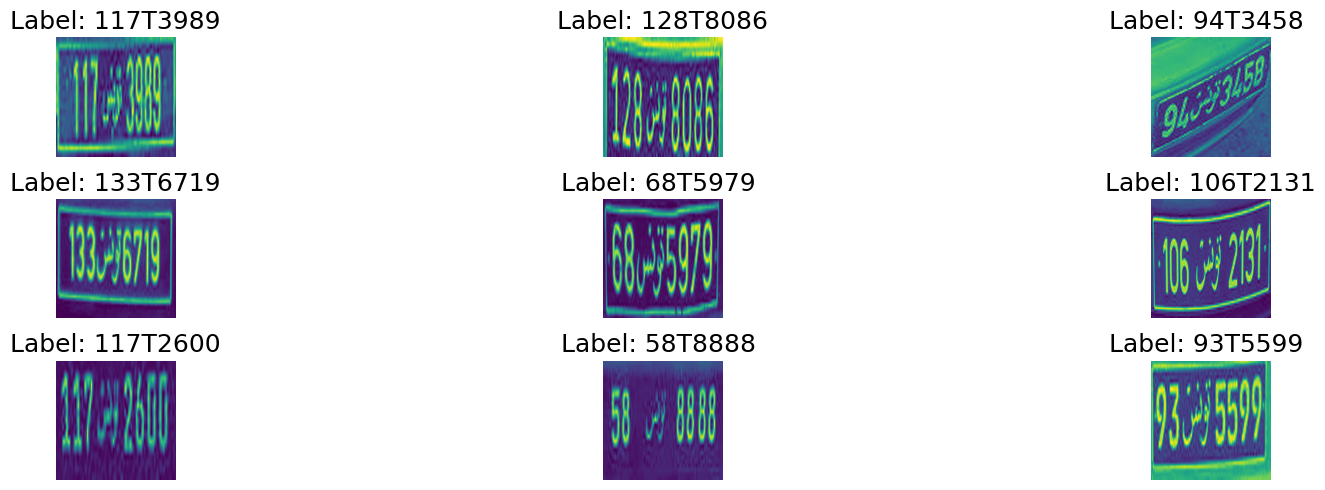

In [ ]:
import matplotlib.pyplot as plt

# Display first 9 images from the training set with their labels
plt.figure(figsize=(20, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i][:, :, 0])  # Display grayscale image
    plt.title(f"Label: {y_train[i]}", fontsize=18)  # Show the label as the title
    plt.axis('off')  # Remove axes for cleaner output

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


In [ ]:
batch_size = 20

try:
    DEVICE_NAME = tf.test.gpu_device_name()
    print("Found GPU at: {}".format(DEVICE_NAME))
except:
    DEVICE_NAME = "/device:CPU:0"
    print("ERROR: Not connected to a GPU runtime.")

def encode_data(image, label):
    image = tf.keras.layers.Rescaling(1.0 / 255)(image)
    image = tf.transpose(image, perm = [1, 0, 2])
    label = char_to_ind(tf.strings.unicode_split(label,
                                input_encoding = "UTF-8"))
    return {"image": image, "label": label}

with tf.device(DEVICE_NAME):
    # Training data.
    train_ds = tf.data.Dataset.from_tensor_slices((X_train,
                                                   y_train))
    train_ds = train_ds.map(encode_data,
               num_parallel_calls = tf.data.AUTOTUNE)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size = tf.data.AUTOTUNE)

    # Validation data.
    valid_ds = tf.data.Dataset.from_tensor_slices((X_valid,
                                                   y_valid))
    valid_ds = valid_ds.map(encode_data,
               num_parallel_calls = tf.data.AUTOTUNE)
    valid_ds = valid_ds.batch(batch_size)
    valid_ds = valid_ds.prefetch(buffer_size = tf.data.AUTOTUNE)

    # Testing data.
    # test_ds = tf.data.Dataset.from_tensor_slices((X_test,
    #                                               y_test))
    # test_ds = test_ds.map(encode_data,
    #           num_parallel_calls = tf.data.AUTOTUNE)
    # test_ds = test_ds.batch(batch_size)
    # test_ds = test_ds.prefetch(buffer_size = tf.data.AUTOTUNE)

Found GPU at: 


In [ ]:
train_ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0

# class CTCLayer(tf.keras.layers.Layer):
#     def __init__(self, name=None):
#         super().__init__(name=name)
#         self.loss_fn = tf.keras.backend.ctc_batch_cost

#     def call(self, y_true, y_pred):
#         # Number of samples in a batch
#         batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
#         # Length of the "time steps"
#         input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
#         input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#         # Length of the labels
#         label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
#         label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#         # Compute CTC loss
#         loss = self.loss_fn(y_true, y_pred, input_length, label_length)
#         self.add_loss(loss)
#         return y_pred

# def make_model(width, height):
#     # Inputs
#     imgs = tf.keras.layers.Input(shape=(width, height, 3), name="image", dtype="float32")
#     labels = tf.keras.layers.Input(name="label", shape=(None,), dtype="int64")

#     # EfficientNet as feature extractor
#     base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(width, height, 3))

#     # Reduce downsampling by modifying the EfficientNet backbone
#     x = base_model(imgs)
#     x = tf.keras.layers.Conv2D(128, (1, 1), activation="relu", padding="same")(x)  # Reduce dimensionality

#     # Reduce temporal downsampling
#     x = tf.keras.layers.UpSampling2D(size=(2, 1))(x)  # Upsample along the time axis to restore sequence length

#     # Flatten features for sequence processing
#     new_shape = (-1, x.shape[-1])  # Sequence length inferred
#     x = tf.keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)

#     # RNN layers for sequence modeling
#     x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.5))(x)
#     x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.5))(x)

#     # Dense output layer before the CTC loss
#     x = tf.keras.layers.Dense(len(char_to_ind.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

#     # CTC loss layer
#     output = CTCLayer(name="ctc_loss")(labels, x)

#     # Create and compile the model
#     model = tf.keras.models.Model(inputs=[imgs, labels], outputs=output, name="ocr_model")
#     opt = tf.keras.optimizers.Adam()
#     model.compile(optimizer=opt, run_eagerly=True)  # Use eager execution for debugging
#     return model



In [ ]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name = None):
        super().__init__(name = name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Number of samples in a batch.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
        # Length of the "time steps".
        input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
        input_length = input_length * tf.ones(shape = (batch_len,
                                             1), dtype = "int64")
        # Length of the label.
        label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")
        label_length = label_length * tf.ones(shape = (batch_len,
                                             1), dtype = "int64")
        loss = self.loss_fn(y_true, y_pred,
                input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [ ]:
def make_model(width, height):
    # Inputs
    imgs = tf.keras.layers.Input(shape = (width, height, 1), name = "image", dtype = "float32")
    labels = tf.keras.layers.Input(name = "label", shape = (None,), dtype = "float32")

    # CNN layers.
    x = tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", kernel_initializer = "he_normal", padding = "same", name = "Conv1")(imgs)
    x = tf.keras.layers.MaxPooling2D((2, 2), name = "pool1")(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", kernel_initializer = "he_normal",padding = "same", name = "Conv2")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name = "pool2")(x)

    # Dense layers. After 2 layers of max pooling, the width and
    # height are reduced by a factor of 4. The factor of 64 comes from the
    # number of filters in the previous CNN layer.
    new_shape = ((width // 4), (height // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape = new_shape, name = "reshape")(x)
    x = tf.keras.layers.Dense(1024, activation = "relu", name = "dense1")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # RNN layers.
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences = True, dropout = 0.5))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True, dropout = 0.5))(x)

    # Dense output layer before the CTC loss. The number of nodes
    # is the number of unique words + 1. The additional node is for
    # a special token which accounts for unknown characters.
    x = tf.keras.layers.Dense(len(char_to_ind.get_vocabulary()) + 1, activation = "softmax", name = "dense2")(x)

    # CTC loss layer.
    output = CTCLayer(name = "ctc_loss")(labels, x)

    model = tf.keras.models.Model(inputs = [imgs, labels], outputs = output, name = "ocr_model")
    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer = opt)
    return model


In [ ]:

with tf.device(DEVICE_NAME):
    model = make_model(width, height)
    model.summary()
    train_hist = {}

Model: "ocr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ image[0][0]            │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 7, 7, 128)      │        163,968 │ efficientnetb0[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 14, 7, 128)     │              0 │ conv2d[0][0]           │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 98, 128)        │              0 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 98, 512)        │        788,480 │ reshape[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 98, 256)        │        656,384 │ bidirectional_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 98, 14)         │          3,598 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 98, 14)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,662,001 (21.60 MB)

 Trainable params: 5,619,978 (21.44 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
print("Model Inputs:", model.inputs)

Model Inputs: [<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=image>, <KerasTensor shape=(None, None), dtype=int64, sparse=False, name=label>]


In [ ]:

epochs = 50

history = model.fit(train_ds, epochs = epochs, validation_data = valid_ds, verbose = 2)

for k in history.history.keys():
    if k not in train_hist:
        train_hist[k] = []
    train_hist[k] = train_hist[k] + history.history[k]


Epoch 1/50
41/41 - 659s - 16s/step - loss: 647.5529 - val_loss: 397.6328
Epoch 2/50
41/41 - 716s - 17s/step - loss: 398.8736 - val_loss: 371.4971
Epoch 3/50


KeyboardInterrupt: 

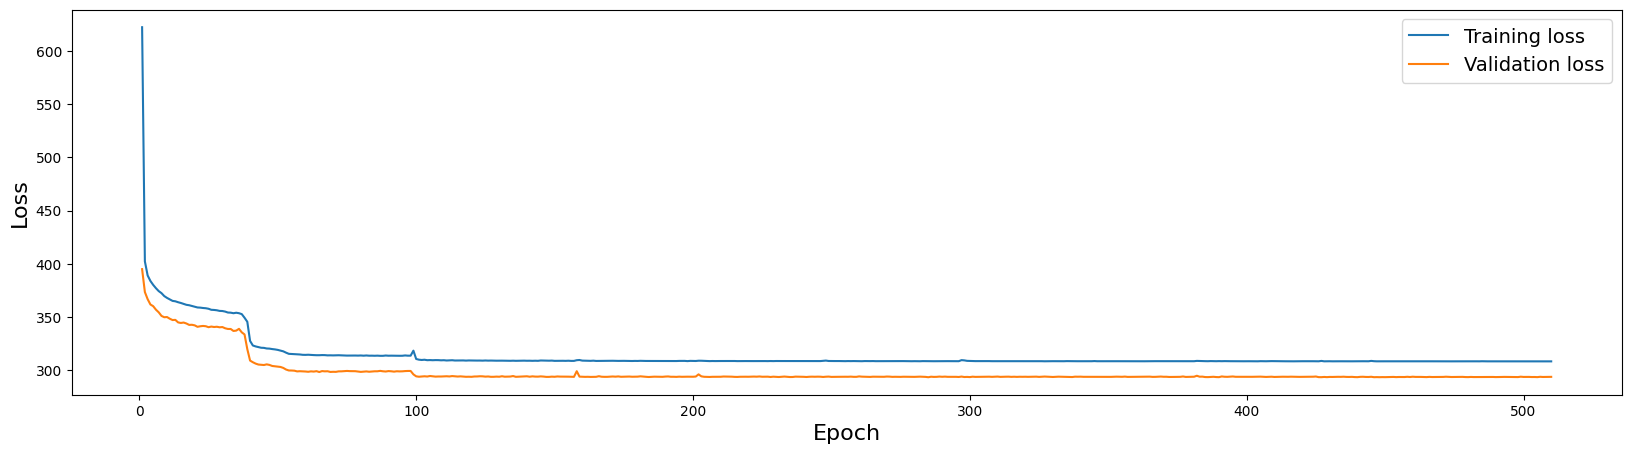

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(range(1, len(train_hist["loss"]) + 1),
         train_hist["loss"])
plt.plot(range(1, len(train_hist["val_loss"]) + 1),
         train_hist["val_loss"])
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.legend(["Training loss", "Validation loss"], fontsize = 14)
plt.show()

In [ ]:
valid_ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 256, 128, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [ ]:
max_len = 8

def decode_batch_predictions(pred, max_len = 10):
    # input_len is the product of the batch size and the
    # number of time steps.
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    # Decode CTC predictions using greedy search.
    # decoded is a tuple with 2 elements.
    decoded = tf.keras.backend.ctc_decode(pred,
                      input_length = input_len,
                                 greedy = True)
    # The outputs are in the first element of the tuple.
    # Additionally, the first element is actually a list,
    # therefore we take the first element of that list as well.
    decoded = decoded[0][0][:, :max_len]

    output = []
    for d in decoded:
        # Convert the predicted indices to the corresponding chars.
        d = tf.strings.reduce_join(ind_to_char(d))
        d = d.numpy().decode("utf-8")
        output.append(d)
    return output
# Create the prediction model.
prediction_model = tf.keras.models.Model(
    inputs=model.inputs[0],  # Directly reference the full model's input
    outputs=model.get_layer(name="dense2").output  # Correct output layer
)

# Predictions for the test dataset.
y_pred = []
y_true = []
for batch in valid_ds:
    batch_images = batch["image"]
    batch_labels = batch["label"]
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds, max_len = max_len)
    y_pred = y_pred + pred_texts
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(ind_to_char(label))
        label = label.numpy().decode("utf-8")
        orig_texts.append(label)
    y_true = y_true + orig_texts


for i in range(10):
    print("{} : {}.".format(y_true[i].strip("[UNK]"), y_pred[i].strip("[UNK]")))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
137T5115 : .
100T8109 : .
109T2328 : .
115T6064 : .
87T9170 : .
168T1951 : .
142T8217 : .
159T3782 : .
161T3015 : .
123T3112 : .


In [ ]:
def similarity(x, y):
    return SequenceMatcher(None, x, y).ratio()

similarities = np.array([0] * len(y_true))

for i in range(len(y_true)):
    similarities[i] = similarity(y_true[i].strip("[UNK]"), y_pred[i].strip("[UNK]"))

print(np.mean(similarities))

0.0


# 8. Test on New Images

In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow

In [ ]:
# Define paths
image_folder = "/content/drive/MyDrive/numberplatedetection/test"  # Folder containing images
object_detection_model_path = "/content/output/detector.h5"  # Path to object detection model
ocr_model_path = "/content/output/ocr_model.h5"  # Path to OCR model
csv_output_path = "/content/output/recognized_text.csv"  # Path to save the CSV file


In [ ]:
# Load the models
object_detection_model = load_model(object_detection_model_path)
ocr_model = load_model(ocr_model_path)

In [ ]:
# Function to preprocess the image for OCR model
def preprocess_image(image, target_size=(224, 224)):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, target_size)  # Resize to target size
    img = img_to_array(img)  # Convert to NumPy array
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize
    return img

# Function to decode the OCR model's prediction
def decode_prediction(preds, char_to_ind):
    pred_text = tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0]) * preds.shape[1], greedy=True)[0][0].numpy()
    decoded_text = ''.join([list(char_to_ind.keys())[i] for i in pred_text if i != -1])
    return decoded_text

# Function to recognize text from the cropped image
def recognize_text_from_image(cropped_image, model, char_to_ind):
    preprocessed_image = preprocess_image(cropped_image)
    preds = model.predict(preprocessed_image)
    decoded_text = decode_prediction(preds, char_to_ind)
    return decoded_text

# Function to process all images in a folder and save results to CSV
def process_images_and_save_to_csv(image_folder, object_detection_model, ocr_model, char_to_ind, csv_output_path):
    results = []  # To store results for all images

    # Loop through each image in the folder
    for image_filename in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_filename)

        # Skip non-image files (if any)
        if not image_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        # Load the image
        image = cv2.imread(image_path)
        original_image = image.copy()

        # Preprocess the image for object detection (if needed)
        image_resized = cv2.resize(image, (224, 224))  # Resize for object detection model if needed
        image_resized = np.expand_dims(image_resized, axis=0)  # Add batch dimension
        image_resized = image_resized / 255.0  # Normalize image

        # Predict the bounding box using the object detection model
        preds = object_detection_model.predict(image_resized)[0]
        (startX, startY, endX, endY) = preds

        # Scale bounding box to the original image size
        (h, w) = original_image.shape[:2]
        startX = int(startX * w)
        startY = int(startY * h)
        endX = int(endX * w)
        endY = int(endY * h)

        # Crop the detected region from the image
        cropped_image = original_image[startY:endY, startX:endX]

        # Recognize text from the cropped image using OCR model
        recognized_text = recognize_text_from_image(cropped_image, ocr_model, char_to_ind)

        # Prepare the result: image_id and each character in separate columns
        image_id = os.path.splitext(image_filename)[0]  # Remove file extension for image ID
        result_row = [image_id] + list(recognized_text.ljust(9))  # Add each character, pad to 9 chars

        # Append to results
        results.append(result_row)

    # Create a DataFrame and save to CSV
    columns = ['img_id'] + [f'char_{i}' for i in range(9)]  # Columns for char_0, char_1, ..., char_8
    df = pd.DataFrame(results, columns=columns)
    df.to_csv(csv_output_path, index=False)

    print(f"CSV file saved to {csv_output_path}")





In [ ]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageOps

# Define characters based on your dataset
chars = "0123456789TN"  # Numbers 0-9 and Arabic 'T' and 'N'
chars = sorted([c for c in chars])

# Character to index map and reverse map
char_to_ind = tf.keras.layers.StringLookup(vocabulary=list(chars), mask_token=None)
ind_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_ind.get_vocabulary(), mask_token=None, invert=True)


In [ ]:

# Run the function to process all images and save the results to CSV
process_images_and_save_to_csv(image_folder, object_detection_model, ocr_model, char_to_ind, csv_output_path)